In [1]:
import torch
import numpy as np

print(f'Cuda available: {torch.cuda.is_available()}')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda:0, Device count: 1


#### Init dataset

In [2]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [3]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = './dataset/'

nusc = NuScenes('v1.0-mini', dataroot=DATAROOT, verbose=False)

In [4]:
helper = PredictHelper(nusc)

In [5]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
validation = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
test = get_prediction_challenge_split("val", dataroot=DATAROOT)

print(f'train/val/test: {len(train), len(validation), len(test)}')
train[:5]

train/val/test: (742, 8560, 9041)


['bc38961ca0ac4b14ab90e547ba79fbb6_39586f9d59004284a7114a68825e8eec',
 'bc38961ca0ac4b14ab90e547ba79fbb6_356d81f38dd9473ba590f39e266f54e5',
 'bc38961ca0ac4b14ab90e547ba79fbb6_e0845f5322254dafadbbed75aaa07969',
 'bc38961ca0ac4b14ab90e547ba79fbb6_c923fe08b2ff4e27975d2bf30934383b',
 'bc38961ca0ac4b14ab90e547ba79fbb6_f1e3d9d08f044c439ce86a2d6fcca57b']

In [6]:
# instance_token, sample_token = train[480].split("_")
instance_token, sample_token = train[230].split("_")

In [7]:
history_length = 2
prediction_length = 6

In [8]:
import importlib

import custom_prediction.custom_input_representation.static_layers
import custom_prediction.custom_input_representation.agents
import custom_prediction.custom_input_representation.interface
import custom_prediction.custom_input_representation.combinators

importlib.reload(custom_prediction.custom_input_representation.static_layers)
importlib.reload(custom_prediction.custom_input_representation.agents)
importlib.reload(custom_prediction.custom_input_representation.interface)
importlib.reload(custom_prediction.custom_input_representation.combinators)

<module 'custom_prediction.custom_input_representation.combinators' from 'C:\\Users\\impor\\Desktop\\University\\MasterThesis\\Raster-traffic-motion-prediction\\custom_prediction\\custom_input_representation\\combinators.py'>

#### Image saver

In [25]:
def get_next_sample_token(sample_token):
    my_sample = nusc.get('sample', sample_token)
    return my_sample['next']

In [16]:
my_sample = nusc.get('sample', sample_token)
my_sample

{'token': '3d22d2c87c5b483a914c7e8125326013',
 'timestamp': 1535657117149304,
 'prev': 'a9def8f915cf4bfe9c74b864384ec6c7',
 'next': '286532245ff646a9915070c8b402e487',
 'scene_token': '2fc3753772e241f2ab2cd16a784cc680',
 'data': {'RADAR_FRONT': '2701347e5e174b1db0d6cdf41f7ac175',
  'RADAR_FRONT_LEFT': '6b7a00343ad34ffc906688ccf8cf7376',
  'RADAR_FRONT_RIGHT': '3b10533e84a8493e8853691cbf114736',
  'RADAR_BACK_LEFT': 'd4c077be496a4fab8208ebf56efb958a',
  'RADAR_BACK_RIGHT': '0c6ae22cc2d741f49df5b26e42b4150a',
  'LIDAR_TOP': '852560fcab7e4002b06ae89f2365b712',
  'CAM_FRONT': '3cd43f6baa4e444999eef6cb1c89416a',
  'CAM_FRONT_RIGHT': 'cad69f6d34c14feba05f0be3e779ac68',
  'CAM_BACK_RIGHT': '10373610f5d547bc9452bbcf5e4c6ead',
  'CAM_BACK': 'b1c7a10f7c4945c3b65f4136a152cebf',
  'CAM_BACK_LEFT': '71f4b49960c0418da042e843c6e83137',
  'CAM_FRONT_LEFT': 'd593270a25fe490ca70b90d6ca4b0ec3'},
 'anns': ['211e55367a7144adb2da40f824ccb8b4',
  'a7305a25e1354df687bf969950f99fcd',
  '9bf039b7c4594808bb87872

In [18]:
scene_token = my_sample['scene_token']
scene_token

'2fc3753772e241f2ab2cd16a784cc680'

In [20]:
my_sample = nusc.get('scene', scene_token)
my_sample

{'token': '2fc3753772e241f2ab2cd16a784cc680',
 'log_token': '3a43824b84534c98bda1d07548db5817',
 'nbr_samples': 41,
 'first_sample_token': 'cd9964f8c3d34383b16e9c2997de1ed0',
 'last_sample_token': '8fe9664cec514a58b1184c4fcefda6b5',
 'name': 'scene-0757',
 'description': 'Arrive at busy intersection, bus, wait at intersection, bicycle, peds'}

In [21]:
first_scene_token = my_sample['first_sample_token']

In [35]:
#next_scene_token = get_next_sample_token(first_scene_token)
next_scene_token = get_next_sample_token(next_scene_token)

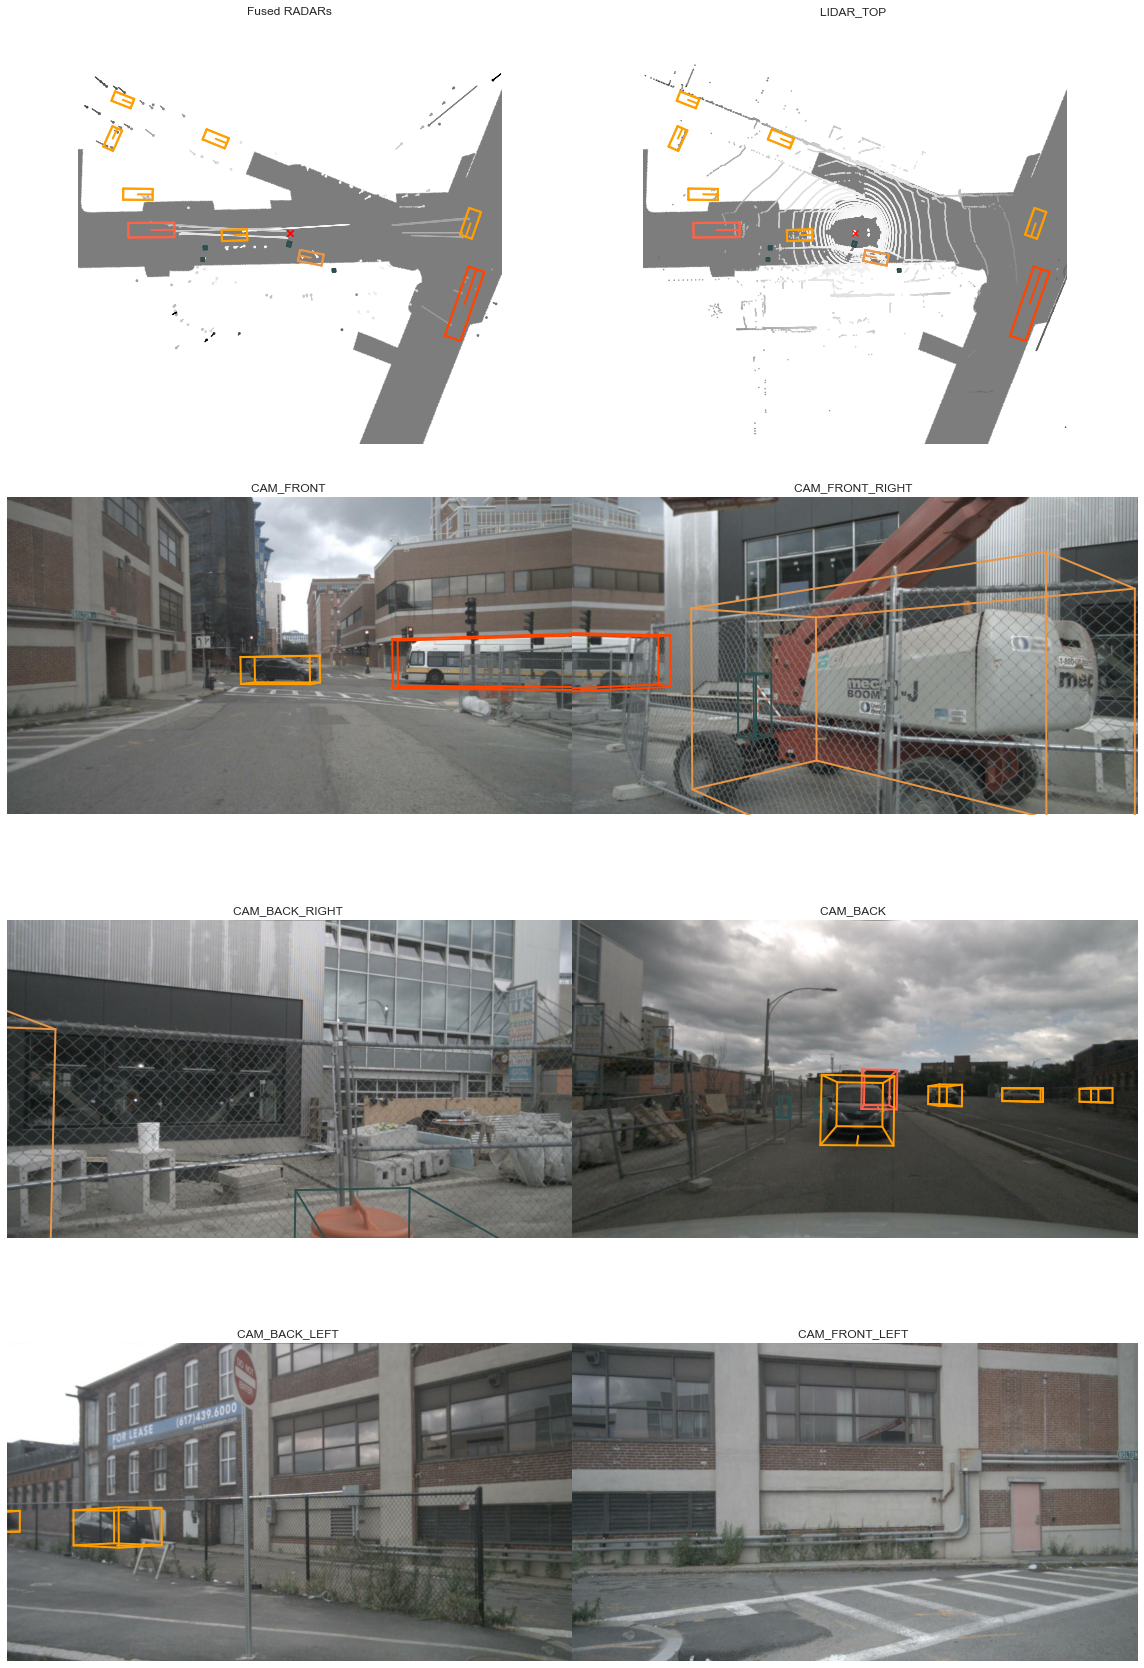

In [36]:
nusc.render_sample(next_scene_token)

In [243]:
import cv2

im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('savedimage_v2.png', im_rgb) 

True

#### State saver

In [13]:
import numpy as np

max_velocity = 26.0
min_accel = -26.0
max_accel = 26.0
min_heading_cr = -1.5
max_heading_cr = 1.5

def value_normalization(value, min_border, max_border):
    if np.isnan(value):
        return -1
    return (value - min_border) / (max_border - min_border)

def get_agent_state(instance_token, sample_token):
    
    # Meters / second.
    vel = helper.get_velocity_for_agent(instance_token, sample_token)

    # Meters / second^2.
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Radians / second.
    heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
    
    #print(f'before: {vel} {accel} {heading_cr}')
    
    vel = value_normalization(vel, 0, max_velocity)
    accel = value_normalization(accel, min_accel, max_accel)
    heading_cr = value_normalization(heading_cr, min_heading_cr, max_heading_cr)
                
    state = np.array([vel, accel, heading_cr])
    
    return state

In [14]:
get_agent_state(instance_token, sample_token)

array([ 0.187407  , -1.        ,  0.49709033])

#### Future trajectory saver

In [15]:
def PlotPathWithPrediction(future, predict=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='g', s=10)
    
    if len(predict) > 0:
        plt.scatter(predict[:, 1], -predict[:, 0], c='yellow', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

In [16]:
def get_future_trajectory(instance_token, sample_token):
    gt = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
    return gt.flatten()

In [17]:
gt = get_future_trajectory(instance_token, sample_token)

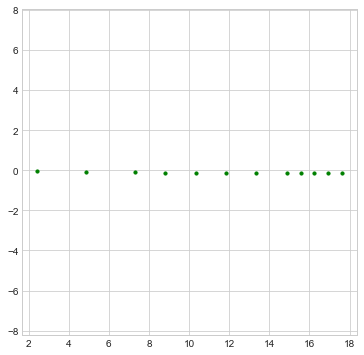

In [18]:
PlotPathWithPrediction(np.reshape(gt, (-1, 2)))

### TODO: Dataset creation

In [19]:
from enum import Enum

class DatasetColumns(Enum):
    FEATURES = 1
    STATES = 2
    LABELS = 3

In [20]:
from tqdm import tqdm

NPY_DATAROOT = './npy_dataset/'

def get_empty_column_batch(samples, column_id):
    if column_id == DatasetColumns.FEATURES:
        return np.empty([len(samples), 500*500*3], dtype=np.uint8)
    
    if column_id == DatasetColumns.STATES:
        return np.empty([len(samples), 3])

    if column_id == DatasetColumns.LABELS:
        return np.empty([len(samples), 2*2*prediction_length])


def generate_column_batch(samples, column_id, file_name):
    
    column_batch = get_empty_column_batch(samples, column_id)
    
    for i, x in enumerate(tqdm(column_batch)):
        instance_token, sample_token = samples[i].split("_")
        
        if column_id == DatasetColumns.FEATURES:
            img = generate_input_representation(instance_token, sample_token)
            row = img.flatten()
            
        if column_id == DatasetColumns.STATES:                
            row = get_agent_state(instance_token, sample_token)
        
        if column_id == DatasetColumns.LABELS:
            row = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
            row = row.flatten()
            
        column_batch[i] = row
        
    np.save(f"{NPY_DATAROOT}{file_name}.npy", column_batch)

In [21]:
# Сохраняет по батчам
batch_size = 5000

def generate_column(samples, column_id, file_name):
    
    for i in range(int(len(samples) / batch_size) + 1):
        
        from_sample = i * batch_size
        to_sample = min((i + 1) * batch_size, len(samples))
        
        print(f"[{i}]{from_sample}:{to_sample}")
        
        batch = samples[from_sample : to_sample]
        generate_column_batch(batch, column_id, file_name + f'_p{i}')

In [22]:
### Test range
before = []
after = []

for sample in validation:
    instance_token, sample_token = sample.split("_")
    
    # Meters / second.
    vel = helper.get_velocity_for_agent(instance_token, sample_token)

    # Meters / second^2.
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Radians / second.
    heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
    
    before.append(accel)
        
    vel = value_normalization(vel, 0, max_velocity)
    accel = value_normalization(accel, min_accel, max_accel)
    heading_cr = value_normalization(heading_cr, min_heading_cr, max_heading_cr)
    
    after.append(accel)
    

In [23]:
before = [x for x in before if abs(x) > 8]

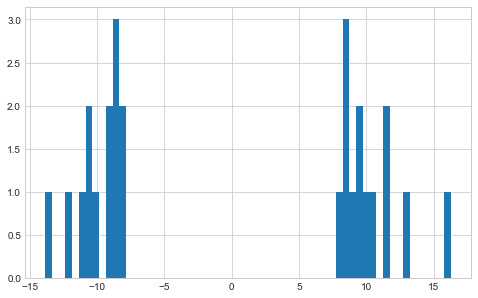

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(before, 60, align='mid')
plt.show()

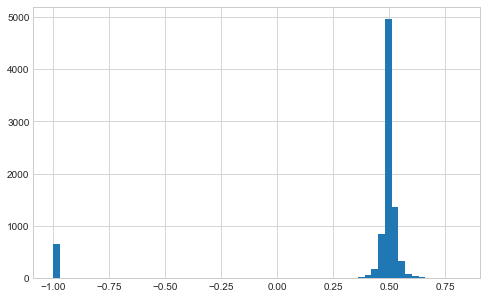

In [25]:
plt.figure(figsize=(8,5))
plt.hist(after, 60, align='mid')
plt.show()

In [34]:
generate_column(train[:100], DatasetColumns.LABELS, 'norm_train_labels')

100%|██████████| 100/100 [00:00<00:00, 1468.24it/s]

[0]0:100


In [35]:
generate_column(validation[:100], DatasetColumns.LABELS, 'norm_validation_labels')

100%|██████████| 100/100 [00:00<00:00, 3927.73it/s]

[0]0:100


### Try to read data and check

In [36]:
import numpy as np

loaded_img = np.load(f'{NPY_DATAROOT}norm_train_features.npy')
# loaded_states = np.load(f'{NPY_DATAROOT}multiagent_test_states_2k.npy')
# loaded_labels = np.load(f'{NPY_DATAROOT}multiagent_test_labels_2k.npy')

In [37]:
len(loaded_img) #, len(loaded_states), len(loaded_labels)

100

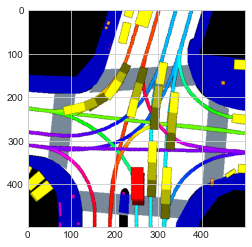

In [39]:
index_to_check = 50

img = loaded_img[index_to_check]
img = img.reshape((500, 500, 3))

plt.imshow(img)
plt.show()

In [42]:
for i in img:
    print(i)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]